## This Notebook Uses The Amazon Reviews Dataset And Predict Whether The Review Is Positive Or Negative

Source of data = https://www.kaggle.com/snap/amazon-fine-food-reviews 

In [111]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.sparse as mat
import warnings
warnings.filterwarnings("ignore")
import scipy.stats
from gensim.models import Word2Vec, KeyedVectors
import eli5
from IPython.display import HTML,display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [56]:
con = sqlite3.connect('database.sqlite')
data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 LIMIT 10000""",con)

In [57]:
data.shape

(10000, 10)

In [58]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [59]:
# To predict the polarity of review, we have to use the scores provided in the data and hence we will convert the score
# into binary values
def Classifier(x):
    if x<3:
        return 0
    return 1
data['Score']=data['Score'].map(Classifier)

In [60]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [61]:
sorted_data = data.sort_values(by = 'ProductId', inplace = False)

In [62]:
sorted_data.shape

(10000, 10)

In [63]:
filtered_data = sorted_data.drop_duplicates(subset ={'UserId','ProfileName','Time','Summary'})

In [64]:
filtered_data.shape

(9560, 10)

In [65]:
data.shape

(10000, 10)

In [66]:
# Now Dropping the rows with no values
final_data=filtered_data.dropna()

In [67]:
final_data.shape

(9560, 10)

No rows were found with missing data, which is great!!!

In [68]:
final_data[final_data['HelpfulnessDenominator']<final_data['HelpfulnessNumerator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


What I find now is that there are 2 rows of data where helpfulness denominator is greater than numerator in my 5000 rows

In [69]:
final=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [70]:
final.shape

(9560, 10)

In [71]:
final.Score.value_counts(normalize=True)

1    0.834205
0    0.165795
Name: Score, dtype: float64

84% of the reviews are positive, and 16% are negative.

In [72]:
final['Score'].value_counts(normalize =True)

1    0.834205
0    0.165795
Name: Score, dtype: float64

In [73]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...


As we see that the data is imbalanced. so accuracy metric will get affected. 
We can do under or oversampling or choose another metric such as log loss.
We will do undersampling because of the computation constraints.

In [74]:
final_data =final

#### Adding another feature - length of text of review

In [75]:
len_rev =[len(i) for i in final_data['Text']]
print(len(len_rev))

9560


#### Sorting according to time, so that we can do time-based split

In [76]:
# sorting the data by time, so that we can do timebased splitting.
final_data.sort_values('Time',inplace=True,ascending=True)

In [77]:
final_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...


In [78]:
final_data.Text[35]  # after randomly reading the reviews, i saw that the reviews had many tags.

"McCann's Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)<br /><br />I'm a fan of the McCann's steel-cut oats, so I thought I'd give the instant variety a try. I found it to be a hardy meal, not too sweet, and great for folks like me (post-bariatric surgery) who need food that is palatable, easily digestible, with fiber but won't make you bloat."

In [79]:
final_data.shape

(9560, 10)

## Preprocessing the text

All the credits to AAIC team for wonderful course.
1. Begin by removing the html tags, we will use beautiful soup for this.
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Wordnet lemmatizer as it is better than snowball stemmer

In [80]:
# importing the libraries needed
import re
import nltk
import string
from bs4 import BeautifulSoup

In [81]:
stopword = nltk.corpus.stopwords.words('english')


In [82]:
lemm = nltk.stem.wordnet.WordNetLemmatizer()
stemm = nltk.stem.SnowballStemmer('english')

In [83]:
#this is how the lemmatizer works
lemm.lemmatize('communities')

'community'

In [84]:
stemm.stem('communities')

'communiti'

In [85]:
stopword = set(stopword)

We will use lemmatizer as it makes use of dictionary and is good for our problem

###  preprocessing the text

In [86]:
def cleaner(phrase):
    # decontraction
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)  # r means raw string
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    #removing words with numbers and special characters
    phrase = re.sub(r"\d\S","", phrase)
    phrase = re.sub(r"\S*\d\S","", phrase).strip()
    phrase = re.sub(r"[^A-Za-z0-9]+"," ",phrase)
    return phrase

In [87]:
from tqdm import tqdm
cleaned_text = []
words = []
for sent in tqdm(final_data['Text'].values):
    sent = BeautifulSoup(sent,'lxml').get_text()
    sent = cleaner(sent)
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopword)
    sent = ' '.join(lemm.lemmatize(e) for e in sent.split())
    cleaned_text.append(sent)

100%|████████████████████████████████████████████████████████████████████████████| 9560/9560 [00:08<00:00, 1178.71it/s]


In [88]:
from tqdm import tqdm
cleaned_summary = []

for sent in tqdm(final_data['Summary'].values):
    sent = BeautifulSoup(sent,'lxml').get_text()
    sent = cleaner(sent)
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopword)
    sent = ' '.join(lemm.lemmatize(e) for e in sent.split())
    cleaned_summary.append(sent)

100%|████████████████████████████████████████████████████████████████████████████| 9560/9560 [00:04<00:00, 2068.10it/s]


In [89]:
#creating new dataframe to increase our features
d = {
    'text':cleaned_text,
    'summary':cleaned_summary,
    'length':len_rev
}

In [90]:
df1 = pd.DataFrame(d)

In [91]:
df1['text+summary'] = df1['text'].map(str)+df1['summary']

In [92]:
df1 = df1.drop(columns = ['text','summary'])

####  Functions That We Will Use

In [93]:
def finding_right_param_model(xtrain,ytrain,xcross,ycross,penalty_value = ''):

    error_on_cv=[]
    error_on_train = []
    roc_cv1 = []
    roc_tr1 = []
    parameter= np.array([0.01,0.1,1,2,5,10])
    for i in tqdm(parameter):
        lr = LogisticRegression(penalty= penalty_value, C=i)

        # fitting the model on crossvalidation train
        lr.fit(xtrain, ytrain)

        # predict the response on the crossvalidation train
        pred = lr.predict_proba(xcross)[:,1]
        pred1 = lr.predict_proba(xtrain)[:,1]

        #ROC_AUC SCORE
        roc_cv= roc_auc_score(ycross,pred)
        roc_cv1.append(roc_cv)
        roc_tr =roc_auc_score(ytrain,pred1)
        roc_tr1.append(roc_tr)
    
    #plotting the roc-auc
    plot1= plt.subplot(1,1,1)
    plt.grid()
    plt.title("Area Under Roc Curve for Train and Cv Data")
    plt.plot(parameter,roc_cv1,label="roc_auc_cv")
    plt.plot(parameter,roc_tr1,label ="roc_auc_tr")
    plt.xlabel('ALPHA')
    plt.ylabel('Area under curve of ROC')
    plt.legend()
    plt.show()



In [94]:
def final_model(xtrain,ytrain,xtestdata,ytestdata,penalty_value = '',param_value = '',vect_type =''):
    # Training the model with the right parameter

    lr = LogisticRegression(penalty=penalty_value,C =param_value)

    # fitting the model on crossvalidation train
    lr.fit(xtrain, ytrain)

    # predict the response on the crossvalidation train
    pred = lr.predict_proba(xtestdata)[:,1]
    pred1 = lr.predict_proba(xtrain)[:,1]
    
    #plotting the roc 
    final_auc_score= roc_auc_score(ytestdata,pred)
    print("*******Final Auc Score is {}*********".format(final_auc_score))
    
    print("**********Important Features are******************")
    if vect_type != '':
        show_most_informative_features(vectorizer = vect_type,clf = lr,penalty=penalty_value,target_names = ytestdata)
    
    #Plotting the roc-curve
    fpr,tpr,threshold = roc_curve(ytestdata,pred)
    fpr1,tpr1,threshold1 = roc_curve(ytrain,pred1)
    plt.figure(2,figsize = (15,4))
    plt.subplot(1,2,1)
    plt.title("Roc Curve For Train and Test Data")
    plt.plot(fpr,tpr,label = "test-roc")
    plt.plot(fpr1,tpr1,label = "train-roc")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    #plotting the confusion matrix
    plt.subplot(1,2,2)
    cm = confusion_matrix(ytestdata,lr.predict(xtestdata))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d",center =None)
    plt.title("Confusion Matrix")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.show()


In [95]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def show_most_informative_features(vectorizer, clf, penalty = 'l1',target_names =''):
    feature_names = vectorizer.get_feature_names()
    cnt = 0
    display(HTML(eli5.show_weights(clf, vec=vectorizer, top=15 ,target_names='').data))
    if penalty =='l1':
        print("length of weight vector is {}".format(len(clf.coef_[0])))
        for i in clf.coef_[0]:
            if i != 0:
                cnt+=1
        print("No. of Non-sparse values are {}".format(cnt))
        print("sparsity on weight vector obtained using L1-regu is {}".format(cnt/len(clf.coef_[0])) )
        
    global wt
    wt = clf.coef_[0]

### Text Featurization

#### BAG OF WORDS

In [96]:
df1.shape

(9560, 2)

In [97]:
# splitting the dataframe into train,test,cv dataset 
from sklearn.model_selection import train_test_split as splitter
x,xtest,y,ytest = splitter(df1,final_data['Score'],test_size = 0.2)
xtr,xcv,ytr,ycv = splitter(x,y,test_size=0.2)

In [98]:
#Using Bag of words on text and summary and adding another feature
import sklearn.feature_extraction.text as textfeat
bow = textfeat.CountVectorizer()
bow.fit(xtr['text+summary'])
bow_xtr= bow.transform(xtr['text+summary'])
bow_xcv = bow.transform(xcv['text+summary'])
bow_xtest = bow.transform(xtest['text+summary'])

In [99]:
bow_xcv.shape

(1530, 18926)

In [100]:
bow_xtr.shape

(6118, 18926)

In [101]:
bow_with_other_features_train = mat.hstack([bow_xtr,np.array(xtr['length']).reshape(xtr.shape[0],1)]) # reshaping
bow_with_other_features_cv = mat.hstack([bow_xcv,np.array(xcv['length']).reshape(xcv.shape[0],1)])
bow_with_other_features_test = mat.hstack([bow_xtest,np.array(xtest['length']).reshape(xtest.shape[0],1)])

In [102]:
bow_with_other_features_cv.shape

(1530, 18927)

In [103]:
type(bow_with_other_features_train)

scipy.sparse.coo.coo_matrix

#### Applying logistic regression

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.50it/s]


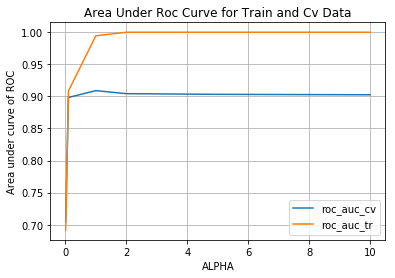

In [104]:
#L1 regularization
finding_right_param_model(bow_with_other_features_train,ytr,bow_with_other_features_cv,ycv,penalty_value='l1')

*******Final Auc Score is 0.8900251155374665*********
**********Important Features are******************


length of weight vector is 18927
No. of Non-sparse values are 943
sparsity on weight vector obtained using L1-regu is 0.04982300417393142


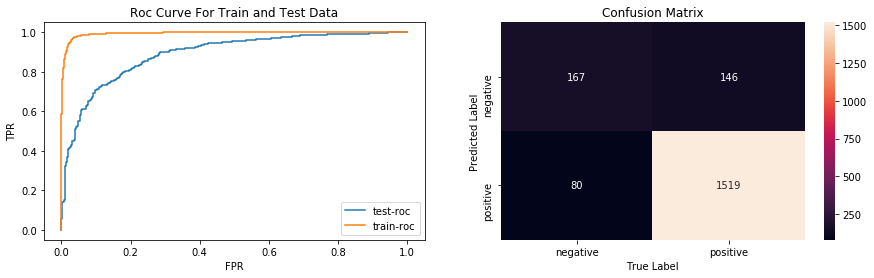

In [105]:
# As we can see that c = 1 is the right alpha for us in bow
final_model(bow_with_other_features_train,ytr,bow_with_other_features_test,ytest,penalty_value='l1',\
            param_value=1,vect_type=bow)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  2.74it/s]


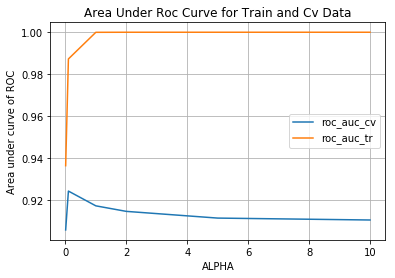

In [106]:
#L2 regularization
finding_right_param_model(bow_with_other_features_train,ytr,bow_with_other_features_cv,ycv,penalty_value='l2')

In [114]:
# As we can see that c = 1 is the right alpha for us in bow
#final_model(bow_with_other_features_train,ytr,bow_with_other_features_test,ytest,penalty_value='l2',\
 #           param_value=1,vect_type=bow)

In [ ]:
old_wt = wt
del wt

Adding Noise To The Dataset To check if features are collinear

In [115]:
"""bow_with_other_features_train.data.astype(dtype = 'float64')
bow_with_other_features_train.data=bow_with_other_features_train.data.astype(dtype = 'float64')\
+scipy.stats.norm.rvs(loc=0,scale=0.1,size = bow_with_other_features_train.data.shape)

bow_with_other_features_cv.data=bow_with_other_features_cv.data.astype(dtype = 'float64')\
+scipy.stats.norm.rvs(loc=0,scale=0.1,size = bow_with_other_features_cv.data.shape)

bow_with_other_features_test.data=bow_with_other_features_test.data.astype(dtype = 'float64')+\
scipy.stats.norm.rvs(loc=0,scale=0.1,size = bow_with_other_features_test.data.shape)
"""

"bow_with_other_features_train.data.astype(dtype = 'float64')\nbow_with_other_features_train.data=bow_with_other_features_train.data.astype(dtype = 'float64')+scipy.stats.norm.rvs(loc=0,scale=0.1,size = bow_with_other_features_train.data.shape)\n\nbow_with_other_features_cv.data=bow_with_other_features_cv.data.astype(dtype = 'float64')+scipy.stats.norm.rvs(loc=0,scale=0.1,size = bow_with_other_features_cv.data.shape)\n\nbow_with_other_features_test.data=bow_with_other_features_test.data.astype(dtype = 'float64')+scipy.stats.norm.rvs(loc=0,scale=0.1,size = bow_with_other_features_test.data.shape)\n"

In [ ]:
#L2 regularization on noisy data
#finding_right_param_model(bow_with_other_features_train,ytr,bow_with_other_features_cv,ycv,penalty_value='l2')

In [118]:
# As we can see that c = 1 is the right alpha for us in bow
#final_model(bow_with_other_features_train,ytr,bow_with_other_features_test,ytest,penalty_value='l2',param_value=1,vect_type=bow)

In [120]:
"""new_wt = wt
old_wt = old_wt+(10^-6)
new_wt = new_wt+(10^-6)
percentage_change_in_weights = np.abs((old_wt-new_wt)/old_wt)*100
percentage = np.linspace(99.99,100,100)
np.percentile(percentage_change_in_weights,percentage)
#Wherever the percent change is high, we want those indices because all the operations were element wise in array
# Therefore, n ot changing the indices
np.argsort(percentage_change_in_weights)[:10]
#Featuers which changed a lot after we added noise to the data
print(np.take(bow.get_feature_names(),np.argsort(percentage_change_in_weights)[:10]))"""

'new_wt = wt\nold_wt = old_wt+(10^-6)\nnew_wt = new_wt+(10^-6)\npercentage_change_in_weights = np.abs((old_wt-new_wt)/old_wt)*100\npercentage = np.linspace(99.99,100,100)\nnp.percentile(percentage_change_in_weights,percentage)\n#Wherever the percent change is high, we want those indices because all the operations were element wise in array\n# Therefore, n ot changing the indices\nnp.argsort(percentage_change_in_weights)[:10]\n#Featuers which changed a lot after we added noise to the data\nprint(np.take(bow.get_feature_names(),np.argsort(percentage_change_in_weights)[:10]))'

### Term Frequency Inverse Document Frequency

In [124]:
#Using Bag of words on text and summary and adding another feature
import sklearn.feature_extraction.text as textfeat
tfidf = textfeat.TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf.fit(xtr['text+summary'])
tfidf_xtr= tfidf.transform(xtr['text+summary'])
tfidf_xcv = tfidf.transform(xcv['text+summary'])
tfidf_xtest = tfidf.transform(xtest['text+summary'])

In [125]:
tfidf_with_other_features_train = mat.hstack([tfidf_xtr,np.array(xtr['length']).reshape(xtr.shape[0],1)]) # reshaping
tfidf_with_other_features_cv = mat.hstack([tfidf_xcv,np.array(xcv['length']).reshape(xcv.shape[0],1)])
tfidf_with_other_features_test = mat.hstack([tfidf_xtest,np.array(xtest['length']).reshape(xtest.shape[0],1)])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.05it/s]


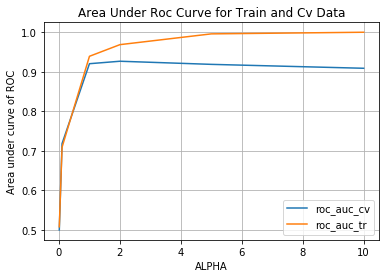

In [126]:
#L1 regularization
finding_right_param_model(tfidf_with_other_features_train,ytr,tfidf_with_other_features_cv,ycv,penalty_value='l1')

*******Final Auc Score is 0.8979154303708188*********
**********Important Features are******************


length of weight vector is 3624
No. of Non-sparse values are 234
sparsity on weight vector obtained using L1-regu is 0.06456953642384106


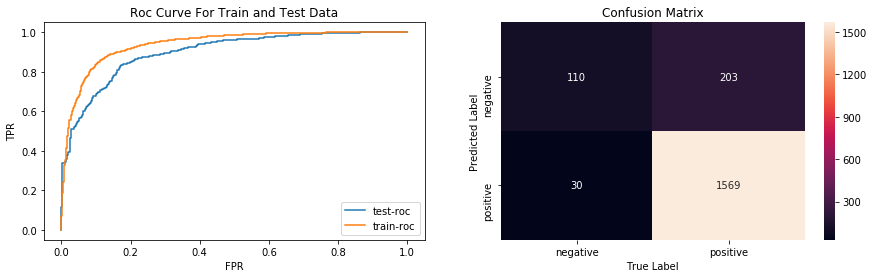

In [127]:
# As we can see that c = 1 is the right alpha for us in bow
final_model(tfidf_with_other_features_train,ytr,tfidf_with_other_features_test,ytest,penalty_value='l1',\
            param_value=1,vect_type=tfidf)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.79it/s]


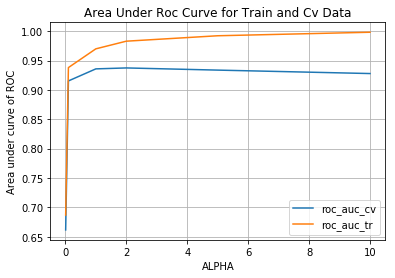

In [128]:
#L2 regularization
finding_right_param_model(tfidf_with_other_features_train,ytr,tfidf_with_other_features_cv,ycv,penalty_value='l2')

*******Final Auc Score is 0.924973076223758*********
**********Important Features are******************


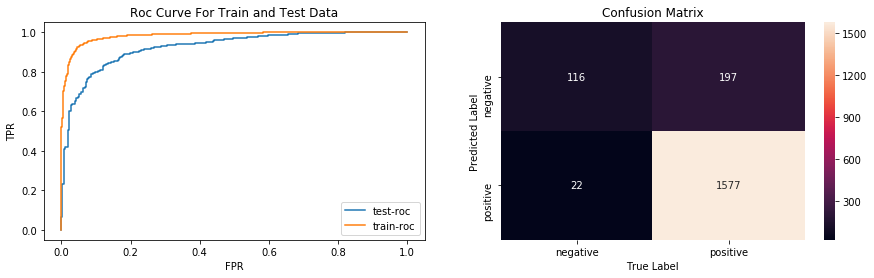

In [129]:
# As we can see that c = 2 is the right alpha for us in bow
final_model(tfidf_with_other_features_train,ytr,tfidf_with_other_features_test,ytest,penalty_value='l2',\
            param_value=2,vect_type=tfidf)

### AVG W2V

In [130]:
word_2_vec = Word2Vec(xtr['text+summary'],size= 40,min_count=4,workers=4)

In [131]:
xtr_vec = []
for sentence in tqdm(xtr['text+summary']):
    word_vec = np.zeros(40)
    cnt_words = 0
    for wor in sentence:
        if wor in word_2_vec:
            wor_vec = word_2_vec.wv[wor]
            word_vec = word_vec+wor_vec
            cnt_words += 1
    if cnt_words != 0:
        sen_vec = word_vec/cnt_words
    xtr_vec.append(sen_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 6118/6118 [00:14<00:00, 415.23it/s]


In [132]:
xcv_vec = []
for sentence in tqdm(xcv['text+summary']):
    word_vec = np.zeros(40)
    cnt_words = 0
    for wor in sentence:
        if wor in word_2_vec:
            wor_vec = word_2_vec.wv[wor]
            word_vec = word_vec+wor_vec
            cnt_words += 1
    if cnt_words != 0:
        sen_vec = word_vec/cnt_words
    xcv_vec.append(sen_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:03<00:00, 486.43it/s]


In [133]:
xtest_vec = []
for sentence in tqdm(xtest['text+summary']):
    word_vec = np.zeros(40)
    cnt_words = 0
    for wor in sentence:
        if wor in word_2_vec:
            wor_vec = word_2_vec.wv[wor]
            word_vec = word_vec+wor_vec
            cnt_words += 1
    if cnt_words != 0:
        sen_vec = word_vec/cnt_words
    xtest_vec.append(sen_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 1912/1912 [00:03<00:00, 500.48it/s]


In [134]:
w2v_with_other_features_train = mat.hstack([np.array(xtr_vec),np.array(xtr['length']).resize(xtr.shape[0],1)]) # reshaping
w2v_with_other_features_cv = mat.hstack([np.array(xcv_vec),np.array(xcv['length']).resize(xcv.shape[0],1)])
w2v_with_other_features_test = mat.hstack([np.array(xtest_vec),np.array(xtest['length']).resize(xtest.shape[0],1)])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.20it/s]


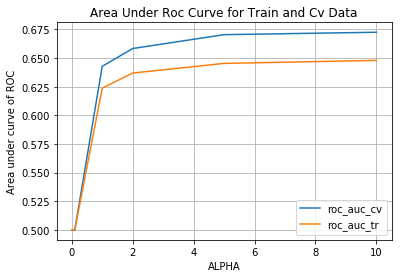

In [135]:
#L1 regularization
finding_right_param_model(w2v_with_other_features_train,ytr,w2v_with_other_features_cv,ycv,penalty_value='l1')

*******Final Auc Score is 0.6200620595539944*********
**********Important Features are******************


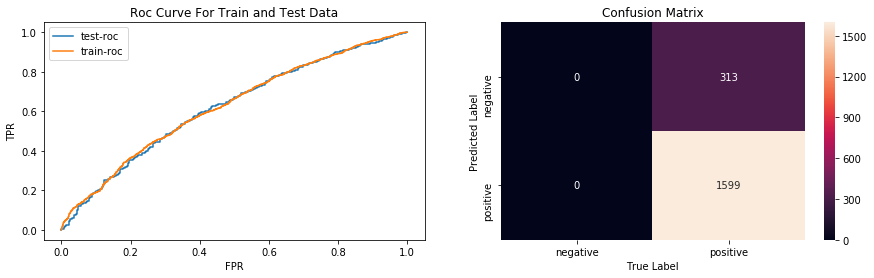

In [136]:
# As we can see that c = 1 is the right alpha for us in bow
final_model(w2v_with_other_features_train,ytr,w2v_with_other_features_test,ytest,penalty_value='l1',\
            param_value=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.29it/s]


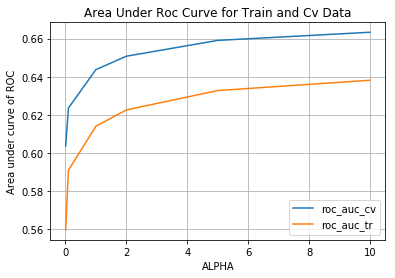

In [137]:
#L2 regularization
finding_right_param_model(w2v_with_other_features_train,ytr,w2v_with_other_features_cv,ycv,penalty_value='l2')

*******Final Auc Score is 0.6193027990737022*********
**********Important Features are******************


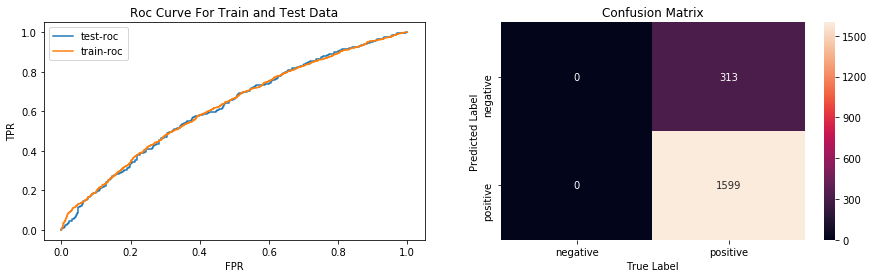

In [138]:
# As we can see that c = 2 is the right alpha for us in bow
final_model(w2v_with_other_features_train,ytr,w2v_with_other_features_test,ytest,penalty_value='l2',\
            param_value=2)

### TFIDF-w2v

In [139]:
model = textfeat.TfidfVectorizer()
tf_idf_matrix = model.fit_transform(cleaned_text)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(xtr['text+summary']): # for each review/sentence 
    sent_vec = np.zeros(40) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in word_2_vec and word in tfidf_feat:
            vec = word_2_vec.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)

100%|██████████████████████████████████████████████████████████████████████████████| 6118/6118 [10:08<00:00,  7.55it/s]


In [140]:
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(xcv['text+summary']): # for each review/sentence 
    sent_vec = np.zeros(40) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in word_2_vec and word in tfidf_feat:
            vec = word_2_vec.wv[word]
            #  tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)

100%|██████████████████████████████████████████████████████████████████████████████| 1530/1530 [04:05<00:00,  7.25it/s]


In [141]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(xtest['text+summary']): # for each review/sentence 
    sent_vec = np.zeros(40) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in word_2_vec and word in tfidf_feat:
            vec = word_2_vec.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)

100%|██████████████████████████████████████████████████████████████████████████████| 1912/1912 [05:14<00:00,  6.08it/s]


In [142]:
tfidf_w2v_with_other_features_train = mat.hstack([np.array(tfidf_sent_vectors_train),np.array(xtr['length'])\
                                                  .resize(xtr.shape[0],1)])
tfidf_w2v_with_other_features_cv = mat.hstack([np.array(tfidf_sent_vectors_cv),np.array(xcv['length']).resize(xcv.shape[0],1)])
tfidf_w2v_with_other_features_test = mat.hstack([np.array(tfidf_sent_vectors_test),np.array(xtest['length']).\
                                                 resize(xtest.shape[0],1)])

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 141.01it/s]


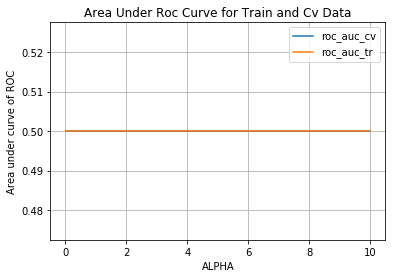

In [143]:
#L1 regularization
finding_right_param_model(tfidf_w2v_with_other_features_train,ytr,tfidf_w2v_with_other_features_cv,ycv,penalty_value='l1')

*******Final Auc Score is 0.5*********
**********Important Features are******************


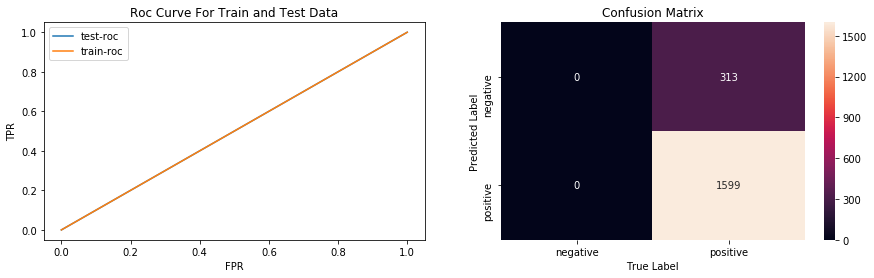

In [144]:
# As we can see that c = 0.01 is the right alpha for us in bow
final_model(tfidf_w2v_with_other_features_train,ytr,tfidf_w2v_with_other_features_test,ytest,penalty_value='l1',\
            param_value=0.1)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 100.27it/s]


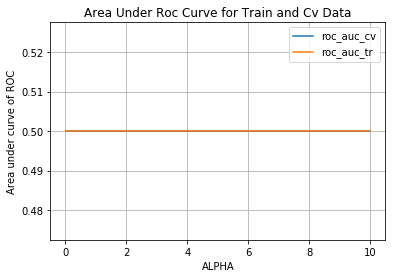

In [145]:
#L2 regularization
finding_right_param_model(tfidf_w2v_with_other_features_train,ytr,tfidf_w2v_with_other_features_cv,ycv,penalty_value='l2')

*******Final Auc Score is 0.5*********
**********Important Features are******************


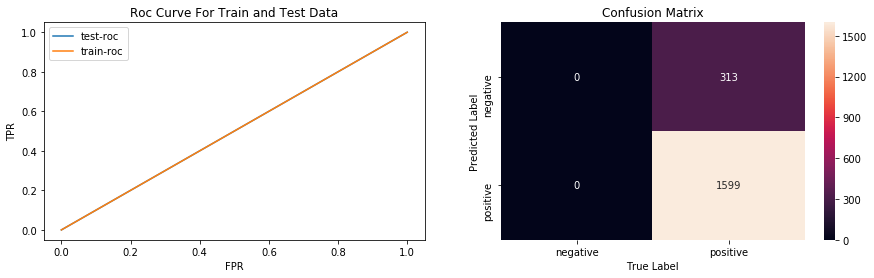

In [146]:
# As we can see that c = 0.01 is the right alpha for us in bow
final_model(tfidf_w2v_with_other_features_train,ytr,tfidf_w2v_with_other_features_test,ytest,penalty_value='l2',\
            param_value=0.1)

### Conclusion

### Performs far better than KNN and NB On Text Data But Since I Can not use google trained w2v and can't train my own due to ram issues. W2V Vectors are performing very bad